# Evaluation of the Random Forest approach for our binary classification task.
TODO Resume what is done overall in the notebook

## Main Logic (Functions we will call later)

In [1]:
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, balanced_accuracy_score


In [3]:
#Load data from file 'selected' and the corresponding labels to predict.
def data_load(selected): 
    if selected in ['1.4-bow_filtered_quantile.npz','1.4-tfidf_filtered_quantile.npz']:
        tab_all = sparse.load_npz(f"./Data/{selected}")
    else:
        tab_all = np.load(f"./Data/{selected}")
    
    Target = pd.read_csv("./Data/target_supervised.csv")
    authors = np.load("./Data/1.3-bow-authors.npy", allow_pickle=True) #same authors for tf-idf. No problem.
    labels = []

    success = True
    for auth in authors:
        # Try to find the first matching row for this author
        match = Target[Target['author'] == auth]

        if not match.empty:
            labels.append(match['gender'].iloc[0])
        else:
            success = False

    if not success:
       print("Unexpected error in reassigning labels.")
       return None, None
    X = tab_all 
    Y = labels
    print(f"X shape: {X.shape}")
    print(f"Y shape: {len(Y)}")

    return X,Y



In [4]:
#Perform training test split with 80-10-10 ratio.
def data_split(X,Y):
    X_temp, X_test, Y_temp, Y_test = train_test_split(X,Y, stratify=Y, train_size=0.90,random_state=16)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, stratify=Y_temp, train_size=8/9, random_state=16)
    print("80-10-10 split")
    print(f"X_train shape:{X_train.shape}")
    print(f"X_val shape:{X_val.shape}")
    print(f"X_test shape:{X_test.shape}")
    return X_train,X_val,X_test,Y_train,Y_val,Y_test

In [5]:
#Train and evaluate a Random Forest model on X,Y
def RF_train_eval(X,Y):
    X_train,X_val,X_test,Y_train,Y_val,Y_test = data_split(X,Y)
    
    randomforest = RandomForestClassifier()
    randomforest.fit(X_train,Y_train)
    y_train_pred = randomforest.predict(X_train)
    y_test_pred = randomforest.predict(X_test)

    print("Performance on Training data")
    print(classification_report(Y_train,y_train_pred))

    print("results on the testing data")
    print(classification_report(Y_test, y_test_pred))

    # get the confusion matrix of test set
    confusion_test = confusion_matrix(Y_test, y_test_pred)

    # visualize the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

### Test correct behaviour 
Let's try on data from one of the four possible pre processing pipelines for now and we will try on the others afterwards.
Testing on bow representation filtered through quantiles.

In [6]:
options = ['1.4-bow_filtered_quantile.npz','1.4-tfidf_filtered_quantile.npz','1.4-bow_svd_reduced.npy','1.4-tfidf_svd_reduced.npy']
selected = options[0]

if selected not in options:
    print("INVALID SELECTION")

In [7]:
X, Y = data_load(selected)

X shape: (4994, 53656)
Y shape: 4994


In [8]:
print(type(X))
print(X.shape)
print(type(Y))
print(Y)

<class 'scipy.sparse._csr.csr_matrix'>
(4994, 53656)
<class 'list'>
[np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64

80-10-10 split
X_train shape:(3994, 53656)
X_val shape:(500, 53656)
X_test shape:(500, 53656)
Performance on Training data
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2916
           1       1.00      0.98      0.99      1078

    accuracy                           1.00      3994
   macro avg       1.00      0.99      0.99      3994
weighted avg       1.00      1.00      1.00      3994

results on the testing data
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       365
           1       0.74      0.32      0.45       135

    accuracy                           0.79       500
   macro avg       0.77      0.64      0.66       500
weighted avg       0.78      0.79      0.75       500



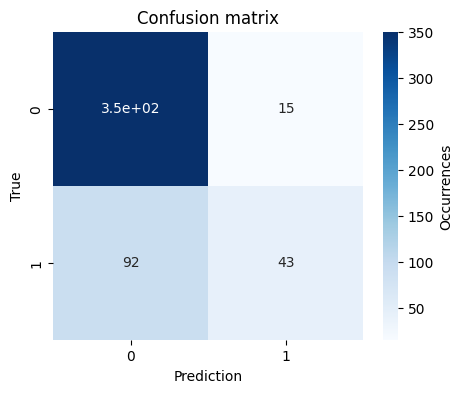

In [9]:
#Create Random Forest model and print results
RF_train_eval(X,Y)

Recall of 0.95 for class 0 (male I think) and 0.32 on class 1 (female) average of 
Clearly the class imbalance has made it favor predicting male causing a poor recall on class 1 and a overall macro average of 0.65 which is not ideal. 

Before we attempt using a XXX to refine hyperparameters for the Decision Tree let's attempt to determine on which pre processing pipeline it performs best.

## 2 Choosing the pipeline
We will try the default parameters of the decision tree on each and pick the one with the best results.
We already have observed the results for 1.4-bow_filtered_quantile.npz so we don't repeat.

1.4-tfidf_filtered_quantile.npz
X shape: (4994, 53656)
Y shape: 4994
80-10-10 split
X_train shape:(3994, 53656)
X_val shape:(500, 53656)
X_test shape:(500, 53656)
Performance on Training data
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2916
           1       1.00      0.98      0.99      1078

    accuracy                           1.00      3994
   macro avg       1.00      0.99      0.99      3994
weighted avg       1.00      1.00      1.00      3994

results on the testing data
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       365
           1       0.96      0.19      0.32       135

    accuracy                           0.78       500
   macro avg       0.87      0.59      0.59       500
weighted avg       0.82      0.78      0.72       500



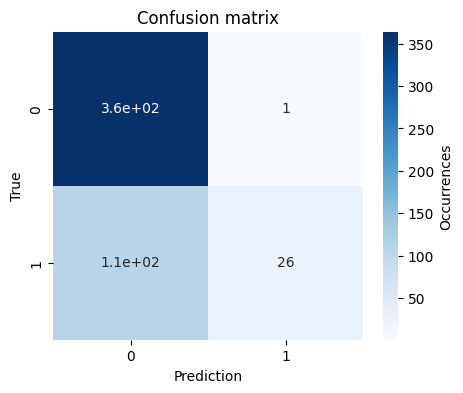

In [10]:
selected = options[1]
print(selected)
X, Y = data_load(selected)
RF_train_eval(X,Y)

1.4-bow_svd_reduced.npy
X shape: (4994, 1000)
Y shape: 4994
80-10-10 split
X_train shape:(3994, 1000)
X_val shape:(500, 1000)
X_test shape:(500, 1000)
Performance on Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2916
           1       1.00      1.00      1.00      1078

    accuracy                           1.00      3994
   macro avg       1.00      1.00      1.00      3994
weighted avg       1.00      1.00      1.00      3994

results on the testing data
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       365
           1       1.00      0.01      0.03       135

    accuracy                           0.73       500
   macro avg       0.87      0.51      0.44       500
weighted avg       0.81      0.73      0.63       500



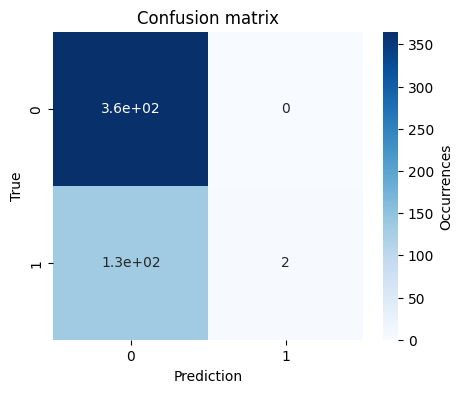

In [11]:
selected = options[2]
print(selected)
X, Y = data_load(selected)
RF_train_eval(X,Y)

1.4-tfidf_svd_reduced.npy
X shape: (4994, 1000)
Y shape: 4994
80-10-10 split
X_train shape:(3994, 1000)
X_val shape:(500, 1000)
X_test shape:(500, 1000)
Performance on Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2916
           1       1.00      1.00      1.00      1078

    accuracy                           1.00      3994
   macro avg       1.00      1.00      1.00      3994
weighted avg       1.00      1.00      1.00      3994

results on the testing data
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       365
           1       0.79      0.16      0.27       135

    accuracy                           0.76       500
   macro avg       0.77      0.57      0.56       500
weighted avg       0.77      0.76      0.70       500



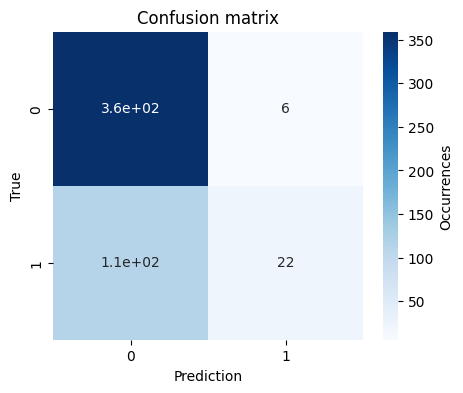

In [12]:
selected = options[3]
print(selected)
X, Y = data_load(selected)
RF_train_eval(X,Y)

### Overview of results
In terms of overall accuracy we have the following results for the use of the following datasets:
1. 0.78 using 1.4-bow_filtered_quantile.npz
2. 0.77 1.4-tfidf_svd_reduced.npy
3. 0.77 1.4-tfidf_filtered_quantile.npy
4. 0.73 using 1.4-bow_svd_reduced.npy

However considering the dataset is rather unbalanced and we may be interested in predicting the minority class (women) as well a more Interesting metric may be the macro_avg recall instead.
1. 0.64 using 1.4-bow_filtered_quantile.npz
2. 0.59 1.4-tfidf_svd_reduced.npy
3. 0.57 1.4-tfidf_filtered_quantile.npz
4. 0.51 1.4-bow_svd_reduced.npy

We notice that the BOW representation filtered through quantiles is the best performing in both metrics and the bow-svd-reduced is the worst performing in both cases.
XXXXXXXXXXXX ADD reason or conclude we can't tell why.

We will as such proceed using the '1.4-bow-filtered_quantile' for the hyperparameter selection using XXX


## Hyper parameter selection through Grid Search

In [13]:
X, Y = data_load('1.4-bow_filtered_quantile.npz')

X shape: (4994, 53656)
Y shape: 4994


In [14]:
'''
RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None,
      min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0,
        warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
'''

"\nRandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, \n    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None,\n      min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0,\n        warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)\n"

In [18]:
# n_estimators - number of Decision trees in the random forest.
estimators = [80,100,120,140]
#min_samples_leaf minimal number
min_samples_leaf = [1,2,3,4]
#function
criterion = ["gini", "entropy", "log_loss"]
#The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss”
#and “entropy” both for the Shannon information gain, see Mathematical formulation.

max_depth = [5,10,20,None] #None is a valid option, corresponds to infinite (no max).
#Max depth for the trees.

In [19]:
X_train,X_val,X_test,Y_train,Y_val,Y_test = data_split(X,Y)

best_parameters = [60,1,"gini",1]
best_balanced_accuracy_score = 0
best_val_pred = None
best_test_pred = None

for est in estimators:
    for min_sam in  min_samples_leaf:
        for crit in criterion:
            for max in max_depth:
                print(f"estimators: {est}, min_samples_leaf: {min_sam}, criterion: {crit}, max: {max}")
                randomforest = RandomForestClassifier(random_state=40,n_estimators=est,min_samples_leaf=min_sam,criterion=crit,max_depth=max)
                randomforest.fit(X_train,Y_train)
                y_val_pred = randomforest.predict(X_val)
                y_test_pred = randomforest.predict(X_test)

                print(accuracy_score(Y_val,y_val_pred))
                print(balanced_accuracy_score(Y_val, y_val_pred))
                if balanced_accuracy_score(Y_val, y_val_pred) > best_balanced_accuracy_score:
                    best_balanced_accuracy_score = balanced_accuracy_score(Y_val, y_val_pred)
                    best_parameters = [est,min_sam,crit,max]
                    best_val_pred = y_val_pred
                    best_test_pred = y_test_pred
                print("\n")

80-10-10 split
X_train shape:(3994, 53656)
X_val shape:(500, 53656)
X_test shape:(500, 53656)
estimators: 80, min_samples_leaf: 1, criterion: gini, max: 5
0.734
0.5074074074074074


estimators: 80, min_samples_leaf: 1, criterion: gini, max: 10
0.734
0.5097412480974125


estimators: 80, min_samples_leaf: 1, criterion: gini, max: 20
0.754
0.5491121258244546


estimators: 80, min_samples_leaf: 1, criterion: gini, max: None
0.758
0.5985286656519533


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: 5
0.734
0.5074074074074074


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: 10
0.732
0.5060375443937087


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: 20
0.75
0.5417047184170471


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: None
0.758
0.589193302891933


estimators: 80, min_samples_leaf: 1, criterion: log_loss, max: 5
0.734
0.5074074074074074


estimators: 80, min_samples_leaf: 1, criterion: log_loss, max: 10
0.732
0.5060375443937087

[140, 1, 'gini', None]
Best Marco avg Recall on validation set: 0.6207508878741755
results on the validation data
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       365
           1       0.67      0.30      0.41       135

    accuracy                           0.77       500
   macro avg       0.73      0.62      0.63       500
weighted avg       0.75      0.77      0.74       500

results on the test data
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       365
           1       0.78      0.31      0.44       135

    accuracy                           0.79       500
   macro avg       0.78      0.64      0.66       500
weighted avg       0.79      0.79      0.76       500



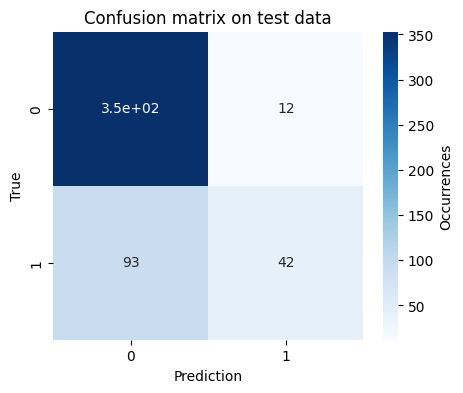

In [17]:
print(best_parameters)
print(f"Best Marco avg Recall on validation set: {best_balanced_accuracy_score}")

print("results on the validation data")
print(classification_report(Y_val, best_val_pred))

print("results on the test data")
print(classification_report(Y_test, best_test_pred))

# get the confusion matrix of test set
confusion_test = confusion_matrix(Y_test, best_test_pred)

# visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix on test data')
plt.show()

As we can see althought we can get a fairly high overall accuracy 0.80 the best marco avg recall we have found is of 0.64, in other words as we see from the confusion matrix most elements of class 1 get incorrectly labelled as class 0, this is no doubt caused by the class imbalance in our dataset. We can also see a significant discrepancy between the results on the training and testing data suggesting overfitting. Let's see if we can improve on these aspects...